# Project 3: Project 3: Web APIs & NLP

### Problem Statement
---

I am a data scientist working at an online dating platform. We asked Reddit for all the posts for the subreddits “Dating over 30”, and “Dating over 40” to identify key words associated with each demographic.

Reddit gave us the posts, but says we have to pay extra to know which posts belong to which subreddit. I am going to save my company money and classify in house.

### Data Dictionary
---

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**subreddit**|*object*|Reddit Pushshift API| Name of subreddit.| 
|**title**|*object*|Reddit Pushshift API| Title of Reddit post.|
|**selftext**|*object*|Reddit Pushshift API| This is the text in the body of the post.|
|**author**|*object*|Reddit Pushshift API| This is the author of the post.|
|**num_comments**|*int64*|Reddit Pushshift API| This is the number of comments to the post.|
|**num_crossplots**|*int64*|Reddit Pushshift API| This is the number of crossplots (shares) of the post.|
|**total_awards_recieved**|*int64*|Reddit Pushshift API| This is the number of awards the reddit post recieved.|
|**upvote_raito**|*float64*|Reddit Pushshift API| This is the raito of upvotes to downvotes of a particlar post.|
|**removed_by_catagory**|*object*|Reddit Pushshift API| This is an indication of who removed the post from the subreddit usualy a moderator.|
|**created_utc**|*int64*|Reddit Pushshift API| This is the time in UTC that the post was published.|
|**url**|*object*|Reddit Pushshift API| This is the direct url of the reddit post.|
|**title_word_count**|*object*|Reddit Pushshift API| Word count of the reddit post title.|
|**selftext_word_count**|*object*|Reddit Pushshift API| Word count of the reddit post selftext.|
|**total_words_count**|*object*|Reddit Pushshift API| Total word count of the subreddits post.|

### Exploratory Data Analysis & Cleaning
---

### Importing libaries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
def vectorize_column(X):
    """
    This Function vectorizes our title or subtext columns so we can      compaire
    frequency and overlap betewen the two subreddits.
    """
    cv = CountVectorizer(stop_words='english')
                                     
                
    cv.fit(X)
    X_transformed = cv.transform(X)
    X_transformed_df = pd.DataFrame(X_transformed.todense(),
                                    columns=cv.get_feature_names())
    return X_transformed_df

def dummify_concat_dataframe(size ,df_1, df_2):
    """
    This function takes in our two dataframes dummifys the subreddit column
    and then concats the two dataframes of equal size to we can better evaluate
    our model.
    """
    df_2 = df_2[['subreddit', 'title', 'selftext', 'total_words']].head(size)
    df_1 = df_1[['subreddit', 'title', 'selftext', 'total_words']].head(size)
    full_frame = pd.concat([df_1, df_2])
    
    #We will dummify the full dataframe 1, if over 30, '0' if over 40
    full_frame['subreddit'] = full_frame['subreddit'].map(lambda x: 1 if x == 'datingoverthirty' else 0)
    
    #add a new index to the DF
    full_frame.index = [i for i in range(full_frame.shape[0])]
    print(f'length of each DataFrame: {size}')
    print(f'length complete DataFrame: {full_frame.shape[0]}')
    print("'1', represents datingover30, '0', represents datingover40")
    return full_frame

### Loading the Data


In [3]:
# Loading in the dataing over 30 csv file as df_30.
df_30 = pd.read_csv('./Raw Reddit Data/raw_date_over_30.csv')

# Loading in the dataing over 40 csv file as df_40.
df_40 = pd.read_csv('./Raw Reddit Data/raw_date_over_40.csv')

### Cleaning the data

Loading in the dataframes the first thing we see is that we have this "[removed]" catagory in selftext column. After doing some research I found that there are quite a few of these "[removed]" labels in dating over 30 dataset and not as many in the dating over 40 dataset. Let us look into this and decide of how to handle this missing data.

In [4]:
# Looking at the unique catagories of who removed the 'selftext'
# we can see that there is are 4 reasons why the self text was removed.
df_30['removed_by_category'].value_counts()

automod_filtered    17188
reddit               2784
moderator            1339
deleted               689
Name: removed_by_category, dtype: int64

In [5]:
# Here again see who removed the 'selftext' in the dataing over 40
# dataset.
df_40['removed_by_category'].value_counts()

moderator    907
reddit       683
deleted      118
Name: removed_by_category, dtype: int64

From here we looked at some samples on reddit of why the self texts were removed. We know that Reddit's core business value is transparancy and free speeh. Even though the selftexts are removed Reddit wants people to see why these posts where removed. I found through looking at several examples of removed selftext that these texts are removed becasue they do not abide by the rules of the subreddit shon below.

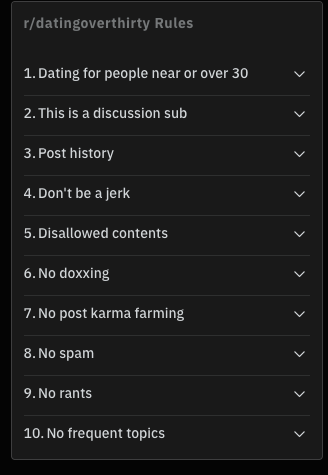

At this point were going to drop all rows where the selftext was removed due to not abiding by the rules of the subreddit. Our reasoning here, is that there are so many reasons why this data would be removed. The main reason is because the post does not bring value to the subreddit, this the same value that we want to extract from this data.

In [6]:
# Dropping the various removed rows by who removed the selftext
df_30.drop(df_30[(df_30['removed_by_category'] == 'automod_filtered') |
                 (df_30['removed_by_category'] == 'reddit') |
                 (df_30['removed_by_category'] == 'moderator') |
                 (df_30['removed_by_category'] == 'deleted')].index, inplace=True)
df_30.shape

(8099, 11)

In [7]:
# Dropping the various removed rows by who removed the selftext
df_40.drop(df_40[(df_40['removed_by_category'] == 'reddit') |
                 (df_40['removed_by_category'] == 'moderator') | 
                 (df_40['removed_by_category'] == 'deleted')].index, inplace=True)
df_40.shape

(6292, 11)

Lets continue our analysis and check for duplicates in the reddit posts.

In [8]:
# Dropping duplicate posts
df_30.drop_duplicates(subset=['title'], inplace=True, keep='first')
print('Size of dating over 30 dataframe after dropping duplicates', df_30.shape[0])

# Dropping duplicate posts
df_40.drop_duplicates(subset=['title'], inplace=True, keep ='first')
print('Size of dating over 40 dataframe after dropping duplicates', df_40.shape[0])

Size of dating over 30 dataframe after dropping duplicates 7869
Size of dating over 40 dataframe after dropping duplicates 6195


We found some duplicates in each dataframe, we will now finally look for null values in the reddit titles and self text and see if we find any.

In [9]:
#Null Values in the 'title' and 'selftext' regions of the posts in dating over 40
df_40[['title', 'selftext']].isnull().sum()

title         0
selftext    893
dtype: int64

In [10]:
#Null Values in the 'title' and 'selftext' regions of the posts in dating over 30
df_30[['title', 'selftext']].isnull().sum()

title         0
selftext    174
dtype: int64

Let's deal with the missing data in the selftext columns in both datasets. I don't want to drop 893 rows of my dating over 40 datasets since that is ~12% of the data in that dataset. We will fill the missing data with an empty string.

In [11]:
#Replaceing NaN values with an empty space
df_40[['selftext']] = df_40[['selftext']].fillna("")

In [12]:
# replacing NaN values with empty space.
df_30[['selftext']] = df_30[['selftext']].fillna("")

We will now create a new feature that encompasses both the "Title" column and the "Selftext" column, and name it total words, perhaps this will help our model train better with more words specific to either SubReddit.

In [13]:
#Creating new row named 'total_words'
df_40['total_words'] = df_40['title'] + df_40['selftext']
df_30['total_words'] = df_30['title'] + df_30['selftext']

In [14]:
# Word Counts of posts titles in both sub reddits
df_30['title_word_count'] = [len(i.split()) for i in df_30['title']]
df_40['title_word_count'] = [len(i.split()) for i in df_40['title']]

In [15]:
# Word Counts of posts selftext in both sub reddits
df_30['selftext_word_count'] = [len(str(i).split()) for i in df_30['selftext']]
df_40['selftext_word_count'] = [len(str(i).split()) for i in df_40['selftext']]

In [16]:
# Word Counts of posts selftext in both sub reddits
df_30['total_words_count'] = [len(str(i).split()) for i in df_30['total_words']]
df_40['total_words_count'] = [len(str(i).split()) for i in df_40['total_words']]

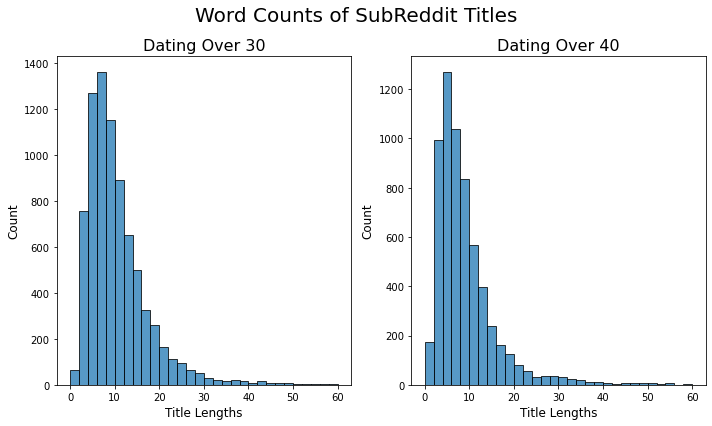

In [17]:
# Histplots of title word lengths of both subreddits 
fig, ax = plt.subplots(
    1,
    2,
    figsize=(10,6),
    tight_layout=True,)

sns.histplot(df_30,
            x="title_word_count",
            bins= 30,
            ax = ax[0],
            binrange=[0, 60]
            )

sns.histplot(df_40,
            x="title_word_count",
            bins=30,
            ax = ax[1],
            binrange=[0, 60]
            );

ax[0].set_xlabel('Title Lengths', fontsize=12)
ax[1].set_xlabel('Title Lengths', fontsize=12)

ax[0].set_ylabel('Count', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

ax[0].set_title('Dating Over 30', fontsize=16)
ax[1].set_title('Dating Over 40', fontsize=16)
fig.suptitle('Word Counts of SubReddit Titles', fontsize=20);

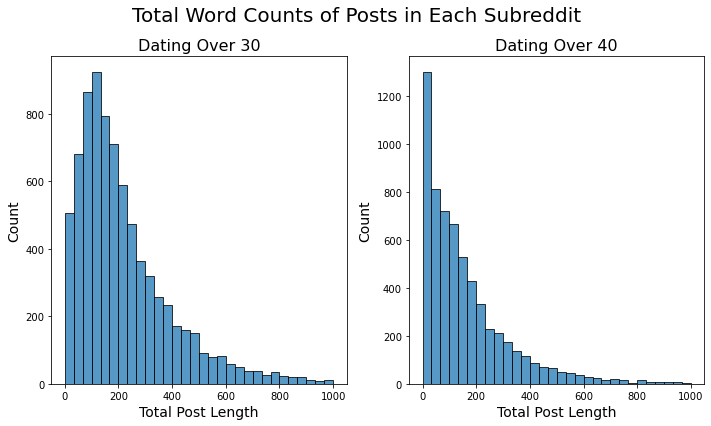

In [18]:
# Histplots of 'total_words' catagory word lengths of both subreddits 
fig, ax = plt.subplots(
    1,
    2,
    figsize=(10,6),
    tight_layout=True,)

sns.histplot(df_30,
            x="total_words_count",
            bins= 30,
            ax = ax[0],
            binrange=[0, 1000]
            )

sns.histplot(df_40,
            x="total_words_count",
            bins=30,
            ax = ax[1],
            binrange= [0, 1000]
            );

ax[0].set_xlabel('Total Post Length', fontsize=14)
ax[1].set_xlabel('Total Post Length', fontsize=14)

ax[0].set_ylabel('Count', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)

ax[0].set_title('Dating Over 30', fontsize=16)
ax[1].set_title('Dating Over 40', fontsize=16)
fig.suptitle('Total Word Counts of Posts in Each Subreddit', fontsize=20);

In [19]:
# Satistical Data of Dating over 30.
df_30[['title_word_count','total_words_count']].describe()

,title_word_count,total_words_count
count,7869.000000,7869.000000
mean,10.048418,230.499047
std,7.127645,207.974708
min,1.000000,1.000000
25%,5.000000,96.000000
50%,8.000000,174.000000
75%,13.000000,299.000000
max,63.000000,2799.000000


In [20]:
# including the mode of title word counts.
df_30['title_word_count'].mode()

0    6
dtype: int64

In [21]:
# include the mode of the total word counts.
df_30['total_words_count'].mode()

0    44
dtype: int64

In [22]:
# Analysis of the distribution of dating over 40 total word counts.
df_40[['title_word_count', 'total_words_count']].describe()

,title_word_count,total_words_count
count,6195.000000,6195.000000
mean,8.590960,163.637450
std,7.229991,180.873856
min,1.000000,1.000000
25%,4.000000,44.000000
50%,7.000000,112.000000
75%,11.000000,218.000000
max,65.000000,2013.000000


In [23]:
# Including the mode of dating over 40 total word count.
df_40['total_words_count'].mode()

0    5
dtype: int64

In [24]:
# including the mode of dating over 40 title word count.
df_40['title_word_count'].mode()

0    5
dtype: int64

## Model the data
---

Lets look at the contraction words like don't and i've the count vecotorizer splits on all punctuations. We wrote a script that pulls apostrophies so we can get a better idea of the top words in our corpus.

In [25]:
# Removing all the commas in contraction words in total_words.
df_30['total_words'] = df_30['total_words'].map(lambda x: x.replace("’",""))
df_40['total_words'] = df_40['total_words'].map(lambda x: x.replace("’",""))

# Removing all the commas in contraction words in selftext.
df_30['selftext'] = df_30['selftext'].map(lambda x: x.replace("’",""))
df_40['selftext'] = df_40['selftext'].map(lambda x: x.replace("’",""))

# Removing all the commas in contraction words in title
df_30['title'] = df_30['title'].map(lambda x: x.replace("’",""))
df_40['title'] = df_40['title'].map(lambda x: x.replace("’",""))

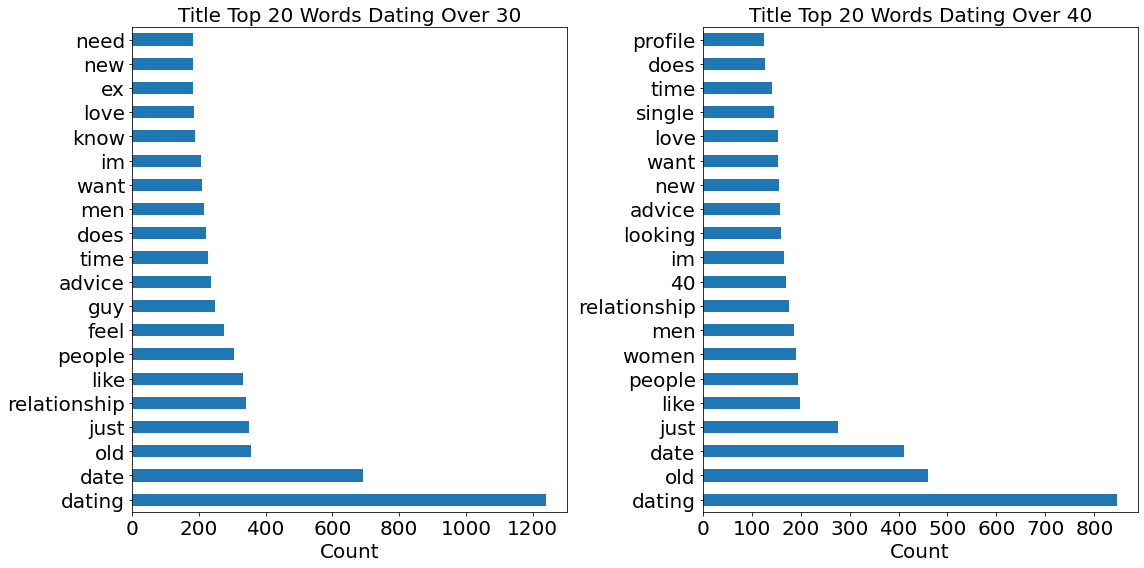

In [26]:
# vectorize title column in dating over 30 and dating over 40
cv_df_30 = vectorize_column(df_30['title'])
cv_df_40 = vectorize_column(df_40['title'])

# Plot 15 most common words in each dataframe
fig, ax = plt.subplots(
    1,
    2,
    figsize=(16,8),
    tight_layout=True,)

cv_df_30.sum().sort_values(ascending=False).head(20).plot(kind='barh',
                                                          ax=ax[0],
                                                          fontsize=20)
cv_df_40.sum().sort_values(ascending=False).head(20).plot(kind='barh',
                                                          ax=ax[1],
                                                          fontsize=20)
ax[0].set_xlabel("Count", fontsize=20)
ax[1].set_xlabel("Count", fontsize=20)                                                        

ax[0].set_title("Title Top 20 Words Dating Over 30", fontsize=20)
ax[1].set_title("Title Top 20 Words Dating Over 40", fontsize=20);

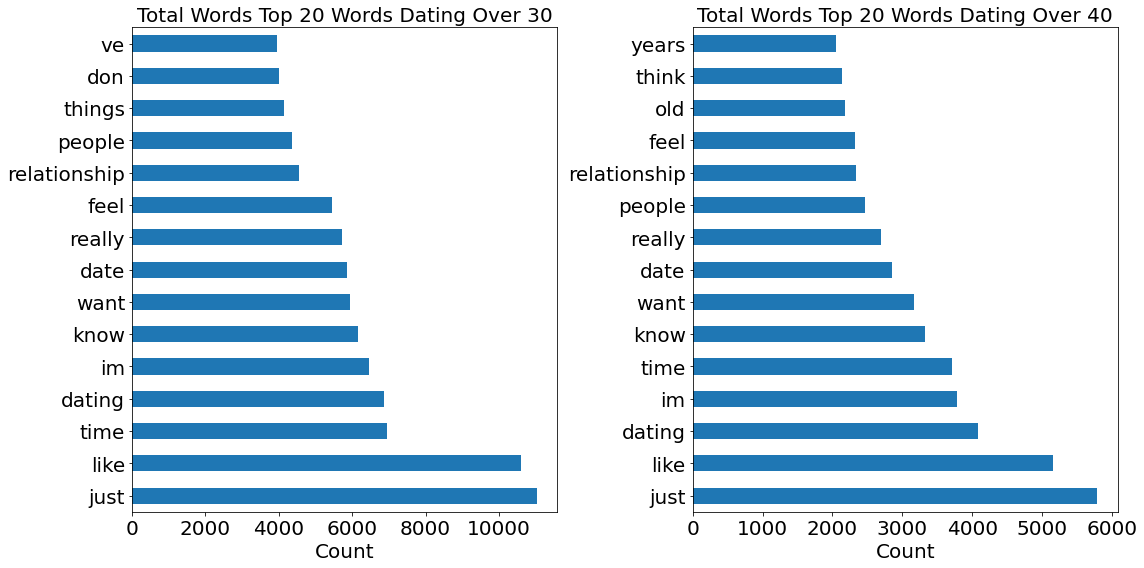

In [27]:
# Vectorize the selftext feature in dating over 30 and dating over 40
cv_df_30_tt = vectorize_column(df_30['total_words'])
cv_df_40_tt = vectorize_column(df_40['total_words'])

fig, ax = plt.subplots(
    1,
    2,
    figsize=(16,8),
    tight_layout=True,)

# Plotting 2 bar charts side by side to show the difference in word choice 
cv_df_30_tt.sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                             ax=ax[0],
                                                             fontsize=20)
cv_df_40_tt.sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                             ax=ax[1],
                                                             fontsize=20)

ax[0].set_xlabel("Count", fontsize=20)
ax[1].set_xlabel("Count", fontsize=20)                                                        

ax[0].set_title("Total Words Top 20 Words Dating Over 30", fontsize=20)
ax[1].set_title("Total Words Top 20 Words Dating Over 40", fontsize=20);

In [28]:
#decalring size and dataframes to be used in our classification model
size = 6100
df_1 = df_30
df_2 = df_40

# Creating a dataframe for our two classification dataframes
df = dummify_concat_dataframe(size,df_1, df_2)

length of each DataFrame: 6100
length complete DataFrame: 12200
'1', represents datingover30, '0', represents datingover40


### Preprocessing & Modeling
---

In [29]:
# define our null model of 55%/45% the data is split in even splits
df['subreddit'].value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

Below we start modeling, we will define our Null Model. From the data 50% is dating over 30 and 50% is dating over 40. Our model should perform above the accuracy of 50% given that mean of positive and negative variables is 50%.

### Mulitnomianl Naive Baise model with Count Vectorizer

Model #1: We start with a Mulitnomianl Naive Baise model with the Count Vectorizer. Multinomial Naive Baise is commonly used to predict variables that are positive intergers and we need the Count Vectorizer to trainsform our data to matrix form.

In [30]:
X = df['total_words']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,stratify = y, random_state=42)

# Pipeline for multinomial count vectorizer with Naive Baise 
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english',
                             max_df=0.1,
                             min_df=1,
                             ngram_range=(1,2),
                             max_features=10000,
                            )),
    ('nb', MultinomialNB(alpha=1,
                         fit_prior=False,))
])

pipe.fit(X_train, y_train);

In [31]:
print('Model Training score: ', pipe.score(X_train, y_train))
print('Model Testing Score: ', pipe.score(X_test, y_test))

Model Training score:  0.8297039393197945
Model Testing Score:  0.7198211624441133


Comment: This is the final form of several interations. We added stop words to the count vectorizer, and ran a Gridseach with our Reddit titles, subtext, and a combination of reddit titles and subtext, each independantly. We found that the best results occoured when we ran the gridseach on the reddit total_text feature. We also found that this model prefered higher max features, 11k I interpret this to mean that model has to dig deeper to find a difference in words. This model also prefers a ngram range of 2 n-grams pairing the words into a group of 2. After several iterations we found that for most of our iterations ~70% accuracy was the best we could do with the data. So from here we started to try different models to see if another model could I perform better on the data given. 

### Multinomial Naïve Bayes model with TF-IDF Vectorizer

Model #2: For our second model we changed the vectorizer from Count Vectorizer to TF-IDF vectorizer. Perhapes with a vectorizer that separates words based on importance we can inprove on our previous model.

In [32]:
# Train test split on 'total_words' feature.
X = df['total_words']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,stratify = y, random_state=42)


# Create a pipeline with Multinomial Naïve Bayes, and TF-IDF Vectorizer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english',
                            binary= True,
                            lowercase=True,
                            max_features=5000,
                            ngram_range=(1,3),
                            )),
    ('nb', MultinomialNB())    
])

# Fit to the pipeline.
pipe_tvec.fit(X_train, y_train);

In [33]:
print('Model Training score: ', pipe_tvec.score(X_train, y_train))
print('Model Testing Score: ', pipe_tvec.score(X_test, y_test))

Model Training score:  0.8065818448739906
Model Testing Score:  0.7143566815697964


Comment: On the previous model we can see that the variance between the training and testing groups has decreased a little. This again is the final tuning of several iterations using the TF-IDF Vectorizer. However, we can see after all of our fine-tuning that the max accuracy of our model seems to stall at 71%. Originally our TF-IDF Vectorizer worked better than the Count Vectorizer since the TF-IDF searches for capital letters. Next, we will move to the Random Forest Model.

### Random Forest Classifer

Let's now move onto Random Forest classifier lets see if ensemble methods will give us a better accuracy, and shine some light onto what are the key features that distinguishes one subreddit from another. 

In [34]:
# Train Test Split on 'total_words' feature.
X = df['total_words']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state=42)

# Create a pipeline of count vectorizer, TF-IDF transformer, and Random Forest Classifer. 
pipe_clf = Pipeline([
    ('cvec', CountVectorizer(stop_words='english',
                             max_df=0.1,
                             max_features=10000,
                             min_df=1,
                             ngram_range=(1,1),
                             )),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(max_depth=None,
                                  max_features='sqrt',
                                  n_estimators= 200))
])
 
# Fit Model/Pipeline     
pipe_clf.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.1, max_features=10000,
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('rf',
                 RandomForestClassifier(max_features='sqrt',
                                        n_estimators=200))])

In [35]:
# Print the results of the Training and testing data.
print('Model Training score: ', pipe_clf.score(X_train, y_train))
print('Model Testing Score: ', pipe_clf.score(X_test, y_test))

Model Training score:  0.9998776608759481
Model Testing Score:  0.7183308494783904


In [36]:
# This will show us the feature importances of what vocabulary the decision trees split on.
importance = pd.Series(pipe_clf.named_steps['rf'].feature_importances_,pipe_clf.named_steps['cvec'].vocabulary_).sort_values(ascending=False).to_frame(name='importance')
importance.head(10)

,importance
hello,0.006496
quite,0.006301
admiration,0.004738
screw,0.004577
subway,0.004173
36f,0.003246
overall,0.003050
recently,0.003038
youre,0.002912
bills,0.002799


Comments: Above we can see the results after several itterations of the RandomForest Classifer. We can see that our accuracy is almost the same as our multinomial Naive Baise model. Also note that the Gridsearch found that the max depth is "None" meaning that it could not find any signifigant feature to split on. We can see a list of feature importances their values are so low that their values can't be taken at value. Next we will move onto the Support Vector Machine Classifer, reading on Sklearn and the research paper, 'Workshop on Computational Personality Recognition: Shared Task'- Luca Rossi and Daniel Gatica-Perez Organizers. I read that SVM's are the best models to classify texual data.

### Support Vector Machine Classifer

We will now model the data on a SVM classifer.

In [46]:
# Train Test Split on 'total_words' feature.
X = df['total_words']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state=42)

# Create a pipeline to vectorize/transfrom and model the Corpus.
pipe_clf = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC())
])

# Fit the Trainning data on the pipeline.
pipe_clf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('svc', SVC())])

In [38]:
print('Model Training score: ', pipe_clf.score(X_train, y_train))
print('Model Testing Score: ', pipe_clf.score(X_test, y_test))

Model Training score:  0.9826278443846342
Model Testing Score:  0.7309985096870343


This was our best Result on the training data an accuracy of 73% lets now look into why our models are having a tough time classifying data to either subreddit. We will look into our confusion matrix and see where the models are having trouble. 

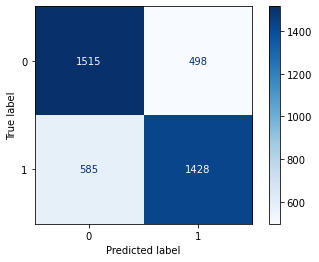

In [39]:
# Getting predictions 
preds = pipe_clf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
plot_confusion_matrix(pipe_clf, X_test, y_test, cmap='Blues');

In [40]:
# Calculate the specificity and precision
spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('specificity:', spec)
print('precision:', prec)

specificity: 0.7526080476900149
precision: 0.7414330218068536


Our Specificity the true negative rate is lower than our precision the true positive rate. I interpret this to mean that the model found it slightly more difficult to classify the dating over 40 subreddit than the dating over 30 subreddit. Let's look at the false negative and false positive classifications and see why our model is having difficulty.

In [41]:
# Create a dataframe of predicted values keeping the original y_test index
results_df = pd.DataFrame(pipe_clf.predict(X_test), index=y_test.index, columns=['predictied'])

# Add an actual values column.
results_df['actual'] = y_test

In [42]:
#created an index of false positive results.
fp_results = results_df[(results_df['actual'] == 1) & (results_df['predictied'] == 0)].index[1]

# created an index false negative results.
fn_results = results_df[(results_df['actual'] == 0) & (results_df['predictied'] == 1)].index[0]

You see below examples of true negative, true positive, false positive, and false negative results. We can see below looking at the titles of the reddit posts that these two subreddits are inherantly simmilar. Our Machine learning algorythems could not train on the data since the posts are relativly simmilar.

In [43]:
print('Example of a false positive result:', df.iloc[fp_results,1])
print('Example of a false negative result:', df.iloc[fn_results,1])

Example of a false positive result: Ive been outta the dating game- new protocol
Example of a false Negative result: Whats it like…


In [44]:
#created an index of True positive results.
tp_results = results_df[(results_df['actual'] == 1) & (results_df['predictied'] == 1)].index[22]

# created an index True negative results.
tn_results = results_df[(results_df['actual'] == 0) & (results_df['predictied'] == 0)].index[21]

In [45]:
print('Example of a True positive result:', df.iloc[tp_results,1])
print('Example of a True Negative result:', df.iloc[tn_results,1])

Example of a True positive result: How to encourage your date to call more over texts?
Example of a True Negative result: Ever wonder, "What's wrong with me?"


### Conclusion and Recommendations
---

Let us return to our original problem statement. We need to classify each post to its original subreddit accurately to save money on fees from Reddit. Given the similarities of our subreddits, our models found it very difficult to train on the unique characteristics of posts from "Dating over 30 and Dating over 40. This is quite understandable since the two age demographics are just 10 years apart and they are going through the same dating problems. I would also make note that the data in dating over 40 was missing about 12% of the 'subtext' column. further robbing us of useful data which might explain the difference in specificity. 

Before this project, I read through several articles and an AAAI technical report and found a few tips on NLP that I would like to look into in future work. The main takeaway is that the best designator for classification is sentiment analysis and lexicon. I would look into a better way to classify the lexicon of the two groups, what do 40-year-olds say that 30-40-year-olds don't. Perhaps the answer lies with emojis or sentiment analysis. Either way, even if we paid Reddit for the information of which subreddit the posts belong to, these posts wouldn't give us much insight into the dating habits of people above 30 and people above 40.